## Final Project Submission

Please fill out:
* Student name: Mac Lambert
* Student pace: self paced
* Scheduled project review date/time: 11/15 5pm ET
* Instructor name: Eli
* Blog post URL: https://medium.com/@ml_85095/dont-repeat-my-visualization-mistake-b16c4f94380f


# High Level Outline

The first step in building this model is to inspect and clean the dataset. We're looking for missing values, unexpected characters and anything that might throw our predictions off.

After cleaning, we'll explore what we have with some introductory data analysis questions. Knowing that this is a dataset of housing sale prices, our questions will be centered around which factors impact the price and how they do that.

Next, we'll dive into building a model to predict the sales price. We'll attempt to use all available data, but columns could be removed for various reasons: a p-value over .05, having no impact on the price, being highly covariant on another variable, etc. If needed, we'll also be transforming values and standardizing where appropriate.
Our R-squared value is the measure of success here; we're looking for something between 70 and 90%. 

After our model is complete, we can use the intercept and coeffecients to summarize the impact each variable has on the final selling price prediction.

# Your code here - remember to use markdown cells for comments as well!

# 1. Importing and Inspecting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

df = pd.read_csv('kc_house_data.csv')

In [2]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


* Okay, we have 21 columns and some obvious missing values in waterfront, yr_renovated
* Let's get a high level view of the dataset and any clean up needed

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [4]:
df.columns[df.isnull().any()]

Index(['waterfront', 'view', 'yr_renovated'], dtype='object')

Columns that need to be investigated: waterfront, view, yr_renovated
* all of these are missing values - some more than others!

In [5]:
print(df.waterfront.value_counts())

0.0    19075
1.0      146
Name: waterfront, dtype: int64


* This is a really low number of waterfront homes!
* I'm going to assume that houses with a waterfront would make sure to report it
* Missing values will become 0/false
* It's also okay to drop this column entirely, given the low number of positive values
* In this instance, the assumption above seems just as safe

In [6]:
# change missing waterfront values to 0
df.waterfront = df.waterfront.fillna(value=0)

In [7]:
print(np.mean(df.yr_renovated))
print(np.median(df.yr_renovated))
print(df.yr_renovated.value_counts())

83.6367783722895
nan
0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64


* Interesting - 17,011 houses have "0.0" for the year renovated - this is obviously not a year!
* So many have missing values that the median is nan!
* I'm going to assume that 0 for year renovated means it wasn't renovated
* Just like waterfront values, missing year renovated will become 0

In [8]:
# change yr_renovated missing value to 0
df.yr_renovated = df.yr_renovated.fillna(value=0)

In [9]:
df.sqft_basement.value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
2350.0        1
1248.0        1
475.0         1
506.0         1
143.0         1
Name: sqft_basement, Length: 304, dtype: int64

* Whoops - sqft_basement includes ? for 454 instances
* Let's change these rows to 0 as well

* We should probably cycle through value_counts() for all columns
* Just because a value is present doesn't mean it's expected - like ? above

* Same idea here - we can assume that a missing view value is 0
* That wouldn't be true if this referred to "quality" of the view of the house
* Instead it's "has been viewed" in the description

In [10]:
# let's force those errors, so we can change them to zeroes
df.sqft_basement = pd.to_numeric(df.sqft_basement, errors='coerce')
df.sqft_basement.head(10)

0       0.0
1     400.0
2       0.0
3     910.0
4       0.0
5    1530.0
6       NaN
7       0.0
8     730.0
9       0.0
Name: sqft_basement, dtype: float64

In [11]:
# change view, sqft_basement missing values to 0
df.view = df.view.fillna(value=0)
df.sqft_basement = df.sqft_basement.fillna(value=0)

In [12]:
df.sqft_basement.value_counts()

0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
915.0         1
295.0         1
1281.0        1
2130.0        1
906.0         1
Name: sqft_basement, Length: 303, dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null float64
yr_built         21597 non-null int64
yr_renovated     21597 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(9), int64(11), object(1)
memory usage: 3.5+ MB


Looks much better!

# 2. Exploratory Data Analysis

* does grade have any impact on selling price?
* what's the relationship between year renovated and sales price?
* most common house size sales
* are sales more or less common in certain areas of the county?

Text(0.5, 1.0, 'Sales Price by Grade')

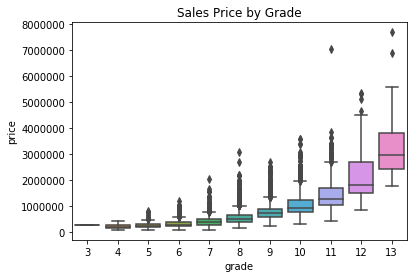

In [14]:
# Let's look at grade vs. price
ax = sns.boxplot(x='grade', y='price', data=df)
plt.title('Sales Price by Grade')
# Yes, definitely
# Especially 10 and above

(1930, 2020)

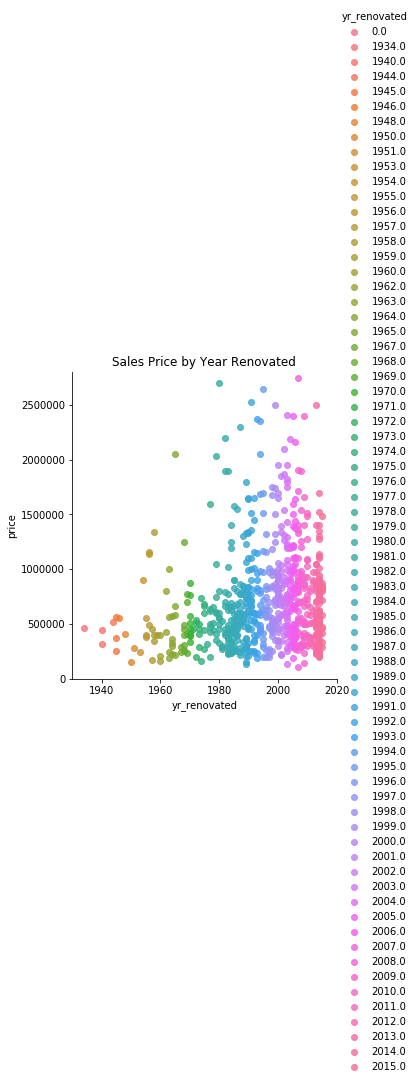

In [15]:
renovation = df[['yr_renovated', 'price']]
renovation.loc[(renovation['yr_renovated']!=0.0)]
display(sns.lmplot(x='yr_renovated', y='price', data=renovation,
           fit_reg=False,
           hue='yr_renovated')) 
plt.title('Sales Price by Year Renovated')
plt.ylim(0, 2800000)
plt.xlim(1930, 2020)
# year renovated certainly has an impact on sales price
# the outliers here are interesting - a renovation pre-1940 suggests a quite old house
# the number of very expensive sales (over 1.5 million) increases as we get into the 2000s

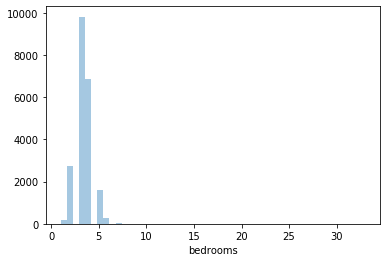

In [16]:
# Now, most common house size sales. Let's use number of bedrooms
ax = sns.distplot(df['bedrooms'], kde=False)
# according to the chart below, we have an outlier

In [17]:
df.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [ ]:
# WOW, that's wild - one house has 33 bedrooms!
# It's interesting, but it's not helpful for seeing the histogram above
# Let's limit the x axis

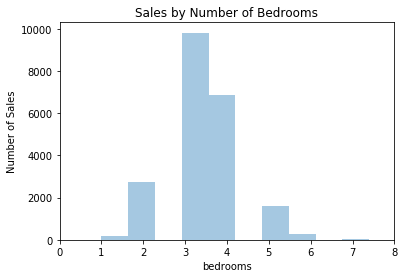

In [18]:
ax = sns.distplot(df['bedrooms'], kde=False)
plt.xlim(0,8)
plt.ylabel('Number of Sales')
plt.title('Sales by Number of Bedrooms')
plt.show()
# based on this plot, the majority of sales were for 3 or 4 bedrooms

In [19]:
# Lastly, let's look at average selling price by zip code
zip_vis = df.groupby(['zipcode'])['price'].mean().astype(int)
print(zip_vis)

zipcode
98001     281194
98002     234284
98003     294111
98004    1356523
98005     810289
          ...   
98177     676419
98178     310612
98188     289078
98198     302896
98199     792187
Name: price, Length: 70, dtype: int64


In [20]:
# Okay, that doesn't tell us much. 
# Let's pull in the price with lat and long and see if we can map it

import folium
from folium import plugins
from folium.plugins import HeatMap

df_map = df[['price', 'lat', 'long']]

map_kc = folium.Map(location=[47.5480, -121.9836],
                    tiles = "Stamen Toner",
                    zoom_start = 9.5)

df_map['lat'] = df_map['lat'].astype(float)
df_map['long'] = df_map['long'].astype(float)
df_map['price'] = df_map['price'].astype(float)

heat_data = [[row['lat'],row['long']] for index, row in df_map.iterrows()]
HeatMap(heat_data).add_to(map_kc)

map_kc
# nothing unexpected here - sales map seems to follow population
# geographical outliers to the east of the map
# there's a bit of a "hole" in the mainland (to the east of Vashon Island) - it's possible this area isn't residential

/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

# 2. Building the Model

* which value has the highest impact on price?
* which "controllable" value has the highest impact? (meaning, you can't change year built but you can change year renovated)

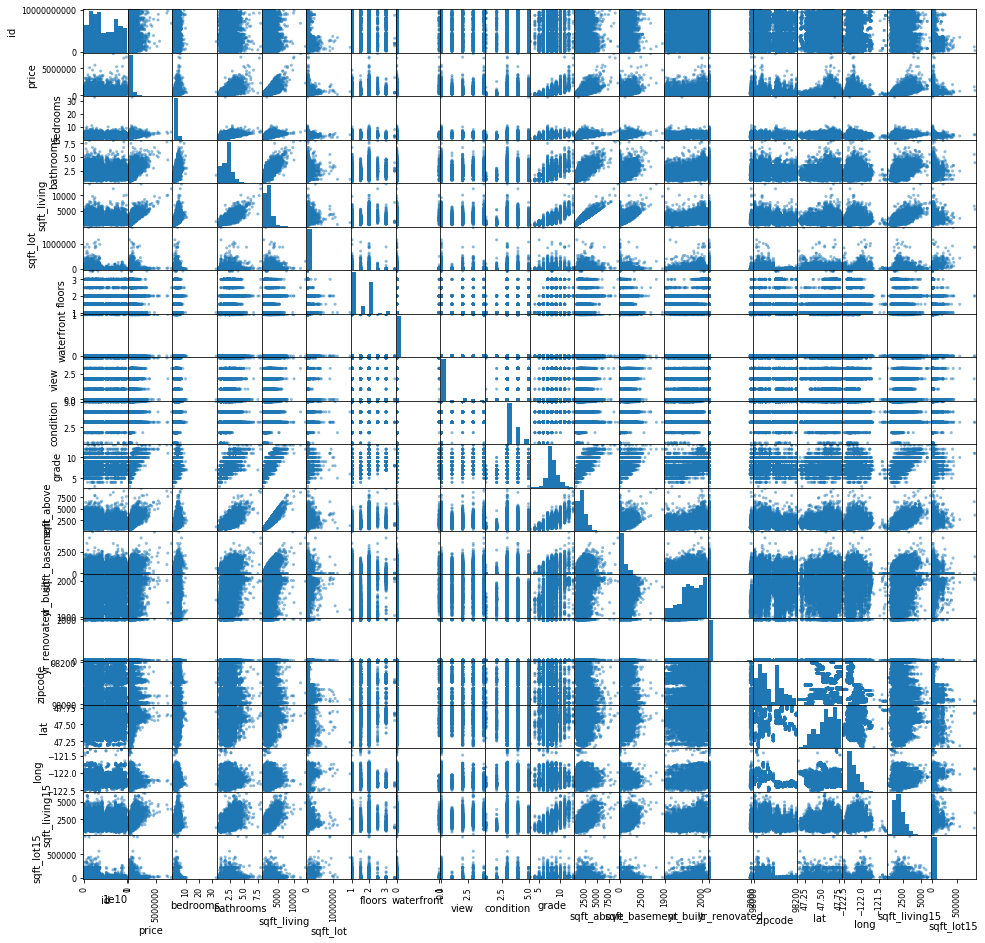

In [21]:
# Here's a high level view of our data:
pd.plotting.scatter_matrix(df,figsize =[16, 16]);
plt.show()

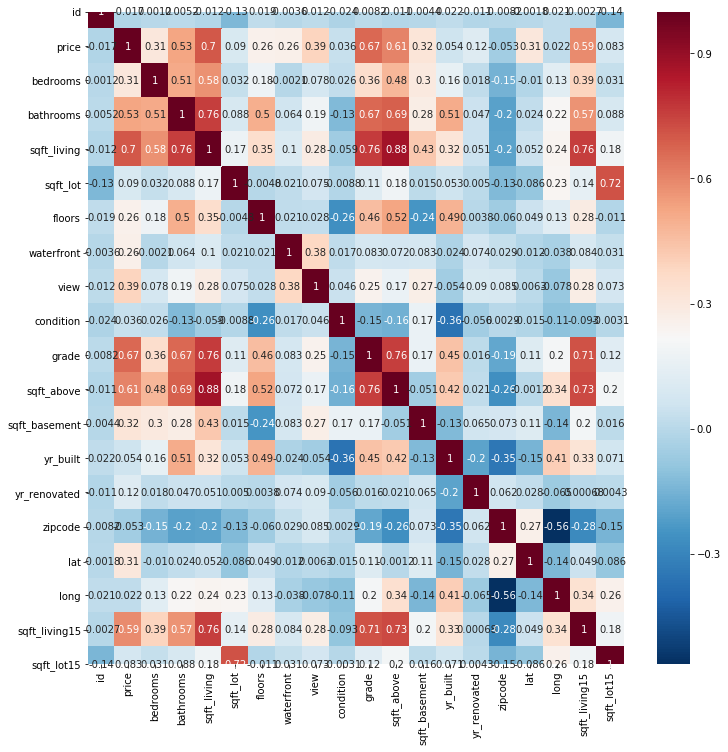

In [22]:
correlation = df.corr()
plt.figure(figsize=(12, 12))
heatmap = sns.heatmap(correlation, annot=True, cmap="RdBu_r")

Based on the above, the columns that are highest impacting on price are:
- sqft_living (.7)
- grade (.67)
- sqft_above (.61)
- sqft_living15 (.59)
- bathrooms (.53)

In [23]:
df.corr()['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.701917
grade            0.667951
sqft_above       0.605368
sqft_living15    0.585241
bathrooms        0.525906
view             0.393497
sqft_basement    0.321108
bedrooms         0.308787
lat              0.306692
waterfront       0.264306
floors           0.256804
yr_renovated     0.117855
sqft_lot         0.089876
sqft_lot15       0.082845
yr_built         0.053953
condition        0.036056
long             0.022036
id              -0.016772
zipcode         -0.053402
Name: price, dtype: float64

Here's another view of that info. 

In [24]:
# Price is the target variable, so let's remove that from the dataset to start our analysis
# ID is also unhelpful in a correlation, so we'll remove that too
# Date will also be dropped, since that's a string

data_pred = df.iloc[:,3:21]
data_pred.head(2)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639


In [25]:
import statsmodels.api as sm
y = df['price']
x = data_pred
X = sm.add_constant(x)

/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [26]:
linreg = sm.OLS(y, X).fit()
linreg.summary()
# here's a view of our model with ALL variables included
# this is just being used as reference
# next, we'll start with the most impacting, as identified above

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     2798.
Date:                Wed, 20 Nov 2019   Prob (F-statistic):               0.00
Time:                        14:47:04   Log-Likelihood:            -2.9439e+05
No. Observations:               21597   AIC:                         5.888e+05
Df Residuals:                   21578   BIC:                         5.890e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.656e+06   2.93e+06      2.271      0.023    9.12e+05    1.24e+07
bedrooms      -3.589e+04   1900.636    -18.882      0.000   -3.96e+04   -3.22e+04
bathrooms      4.162e+04   3262.735     12.755      0.000    3.52e+04     4.8e+04
sqft_living     102.8320     18.076      5.689      0.000      67.401     138.263
sqft_lot          0.1281      0.048      2.673      0.008       0.034       0.222
floors         7000.6499   3600.684      1.944      0.052     -56.956    1.41e+04
waterfront     6.181e+05   1.81e+04     34.082      0.000    5.83e+05    6.54e+05
view           5.329e+04   2122.073     25.111      0.000    4.91e+04    5.74e+04
condition      2.685e+04   2346.458     11.443      0.000    2.23e+04    3.15e+04
grade          9.691e+04   2160.604     44.853      0.000    9.27e+04    1.01e+05
sqft_above       78.0057     18.067      4.318      0.000      42.593     113.419
sqft_basement    47.6352     17.907      2.660      0.008      12.537      82.734
yr_built      -2637.5367     71.932    -36.667      0.000   -2778.528   -2496.545
yr_renovated     23.5856      3.977      5.930      0.000      15.790      31.381
zipcode        -584.4582     32.991    -17.716      0.000    -649.122    -519.794
lat            6.007e+05   1.07e+04     55.939      0.000     5.8e+05    6.22e+05
long          -2.177e+05   1.32e+04    -16.546      0.000   -2.43e+05   -1.92e+05
sqft_living15    21.5139      3.451      6.235      0.000      14.751      28.277
sqft_lot15       -0.3877      0.073     -5.285      0.000      -0.531      -0.244
==============================================================================
Omnibus:                    18343.380   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1833646.592
Skew:                           3.563   Prob(JB):                         0.00
Kurtosis:                      47.575   Cond. No.                     2.15e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
# The value above is quite good - 70% 
# Let's explore other ways we would manipulate the data we have
# First up, the year renovated

In [28]:
# This isn't contributing much to the model now
# Let's see if that changes if we turn it into a binary
df['reno_binary'] = np.where(df['yr_renovated'] > 1, 1,0)
df = df.drop(['yr_renovated'], axis=1)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,reno_binary
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,0.0,1955,98178,47.5112,-122.257,1340,5650,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,98125,47.7210,-122.319,1690,7639,1
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,98028,47.7379,-122.233,2720,8062,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,98136,47.5208,-122.393,1360,5000,0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,98074,47.6168,-122.045,1800,7503,0


In [29]:
# Onto the same for basement!
df.sqft_basement.value_counts()

0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
915.0         1
295.0         1
1281.0        1
2130.0        1
906.0         1
Name: sqft_basement, Length: 303, dtype: int64

Basement has a high number of zeroes. Rather than trying to accurately represent how a higher square footage of basement impacts sales price, let's turn this to a binary as well.

In [30]:
df['basement'] = np.where(df['sqft_basement'] > 1, 1,0)
df = df.drop(['sqft_basement'], axis=1)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,reno_binary,basement
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,1955,98178,47.5112,-122.257,1340,5650,0,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,1951,98125,47.7210,-122.319,1690,7639,1,1
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,1933,98028,47.7379,-122.233,2720,8062,0,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,1965,98136,47.5208,-122.393,1360,5000,0,1
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,1987,98074,47.6168,-122.045,1800,7503,0,0


In [31]:
# next, let's utilize zipcode
# This isn't contributing much to our model now - let's change that.
# Location is a big factor when considering where to buy, as is commute.
# Amazon is a major employer in the area. 
# Let's try to calculate the distance from Amazon HQ using the lat and long of sales data.

from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # Radius of earth in kilometers. Use 3956 for miles
    return c * r
 
# we're going to compare the lat and long against Amazon HQ as either less or greater, as well as distance
# hopefully one of these will contribute to the model in a meaningful way!
    
FIXED_LONG = -122.336344
FIXED_LAT = 47.622266
df['distance'] = df.apply(lambda row: haversine(FIXED_LONG, FIXED_LAT, row['long'], row['lat']), axis=1)
df['greater_long'] = (df['long'] >= FIXED_LONG).astype(int)
df['less_long'] = (df['long'] < FIXED_LONG).astype(int)
df['greater_lat'] = (df['lat'] >= FIXED_LAT).astype(int)
df['less_lat'] = (df['lat'] < FIXED_LAT).astype(int)
df.head()

# shout out to this post for the haversine formula: https://towardsdatascience.com/deeplearning-with-tabular-data-data-processing-cd2e73908257

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,long,sqft_living15,sqft_lot15,reno_binary,basement,distance,greater_long,less_long,greater_lat,less_lat
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,-122.257,1340,5650,0,0,8.512954,1,0,0,1
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,-122.319,1690,7639,1,1,6.864638,1,0,1,0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,-122.233,2720,8062,0,0,9.317873,1,0,1,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,-122.393,1360,5000,0,1,7.486370,0,1,0,1
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,-122.045,1800,7503,0,0,13.564386,1,0,0,1


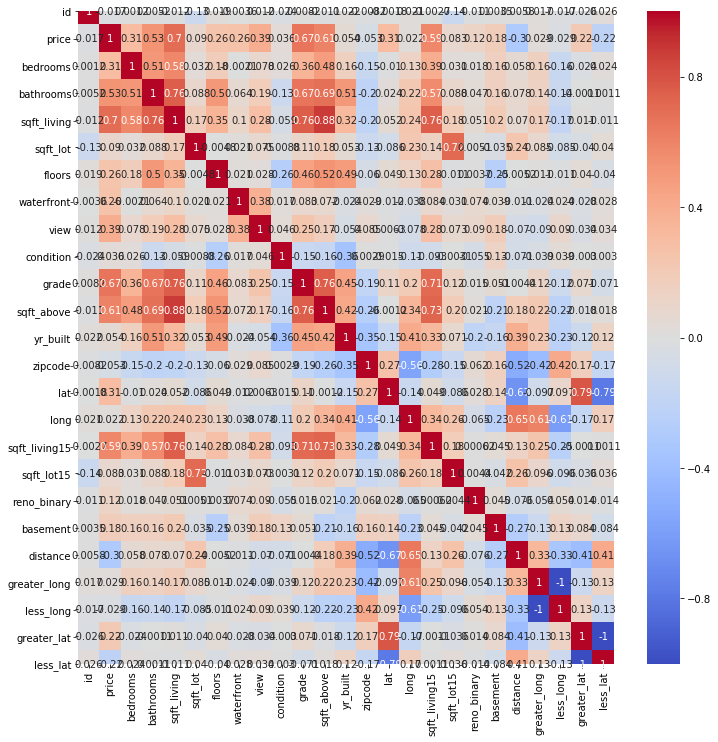

In [32]:
# Now that we've had fun with those variables, let's re-run that heatmap
correlation = df.corr()
plt.figure(figsize=(12, 12))
heatmap = sns.heatmap(correlation, annot=True, cmap="coolwarm")

In [33]:
df.corr()['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.701917
grade            0.667951
sqft_above       0.605368
sqft_living15    0.585241
bathrooms        0.525906
view             0.393497
bedrooms         0.308787
lat              0.306692
waterfront       0.264306
floors           0.256804
greater_lat      0.216971
basement         0.178264
reno_binary      0.117543
sqft_lot         0.089876
sqft_lot15       0.082845
yr_built         0.053953
condition        0.036056
greater_long     0.028529
long             0.022036
id              -0.016772
less_long       -0.028529
zipcode         -0.053402
less_lat        -0.216971
distance        -0.301621
Name: price, dtype: float64

In [34]:
data_pred.head()
# let's add in our basement, distance and renovation info

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [35]:
data_pred = df.iloc[:,3:28]
data_pred.head()
# we could have also done this with concatenation, but this seemed easier
# we know that we added 7 columns onto the right of this dataframe so 21 from before is now 28

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,long,sqft_living15,sqft_lot15,reno_binary,basement,distance,greater_long,less_long,greater_lat,less_lat
0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,...,-122.257,1340,5650,0,0,8.512954,1,0,0,1
1,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,...,-122.319,1690,7639,1,1,6.864638,1,0,1,0
2,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,...,-122.233,2720,8062,0,0,9.317873,1,0,1,0
3,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,...,-122.393,1360,5000,0,1,7.486370,0,1,0,1
4,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,...,-122.045,1800,7503,0,0,13.564386,1,0,0,1


In [36]:
cor_target = abs(correlation['price'])

# let's use only those over .25
highest = cor_target[cor_target>0.25]
highest

price            1.000000
bedrooms         0.308787
bathrooms        0.525906
sqft_living      0.701917
floors           0.256804
waterfront       0.264306
view             0.393497
grade            0.667951
sqft_above       0.605368
lat              0.306692
sqft_living15    0.585241
distance         0.301621
Name: price, dtype: float64

In [37]:
# This may be obvious, but we'll ignore price here as well
# These variables will be used for predicting, so no need for price just yet
most_impacting = df[['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view', 'grade', 'sqft_above', 'lat', 'sqft_living15', 'distance']]
most_impacting

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,sqft_above,lat,sqft_living15,distance
0,3,1.00,1180,1.0,0.0,0.0,7,1180,47.5112,1340,8.512954
1,3,2.25,2570,2.0,0.0,0.0,7,2170,47.7210,1690,6.864638
2,2,1.00,770,1.0,0.0,0.0,6,770,47.7379,2720,9.317873
3,4,3.00,1960,1.0,0.0,0.0,7,1050,47.5208,1360,7.486370
4,3,2.00,1680,1.0,0.0,0.0,8,1680,47.6168,1800,13.564386
...,...,...,...,...,...,...,...,...,...,...,...
21592,3,2.50,1530,3.0,0.0,0.0,8,1530,47.6993,1530,5.337751
21593,4,2.50,2310,2.0,0.0,0.0,8,2310,47.5107,1830,7.795277
21594,2,0.75,1020,2.0,0.0,0.0,7,1020,47.5944,1020,2.593016
21595,3,2.50,1600,2.0,0.0,0.0,8,1600,47.5345,1410,13.848205


In [38]:
# we'll re-run the same ols model with just those above
y = df['price']
x = most_impacting
X = sm.add_constant(x)

In [39]:
linreg = sm.OLS(y, X).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     4697.
Date:                Wed, 20 Nov 2019   Prob (F-statistic):               0.00
Time:                        14:49:37   Log-Likelihood:            -2.9420e+05
No. Observations:               21597   AIC:                         5.884e+05
Df Residuals:                   21585   BIC:                         5.885e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -6.577e+06   6.44e+05    -10.210      0.000   -7.84e+06   -5.31e+06
bedrooms      -2.959e+04   1866.830    -15.849      0.000   -3.32e+04   -2.59e+04
bathrooms      1.431e+04   3046.189      4.697      0.000    8338.408    2.03e+04
sqft_living     149.2211      4.301     34.695      0.000     140.791     157.651
floors        -5.996e+04   3456.852    -17.346      0.000   -6.67e+04   -5.32e+04
waterfront     6.433e+05    1.8e+04     35.835      0.000    6.08e+05    6.79e+05
view           5.571e+04   2068.737     26.928      0.000    5.17e+04    5.98e+04
grade           6.84e+04   2084.633     32.813      0.000    6.43e+04    7.25e+04
sqft_above       70.3254      4.344     16.188      0.000      61.810      78.840
lat            1.352e+05   1.35e+04     10.005      0.000    1.09e+05    1.62e+05
sqft_living15    33.3118      3.342      9.967      0.000      26.761      39.863
distance      -1.675e+04    282.451    -59.300      0.000   -1.73e+04   -1.62e+04
==============================================================================
Omnibus:                    18427.718   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1842698.349
Skew:                           3.591   Prob(JB):                         0.00
Kurtosis:                      47.678   Cond. No.                     1.72e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.72e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

That's pretty cool - our model is already more accurate than the first one, but with fewer variables!

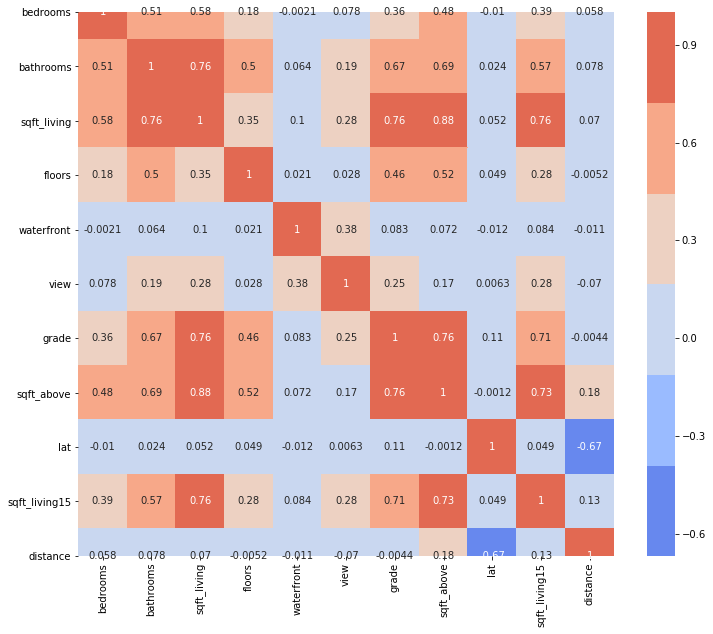

In [40]:
# Let's look for covariance among the predictor variables
corr = most_impacting.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap=sns.color_palette('coolwarm'))
plt.show()

In looking for covariance, we're looking how the relationship between variables could impact the outcome
For example, measuring the sqft and sqin on a bathroom would be double-counting the size of the same room

Based on the above, sqft_living and sqft_above are highly correlated (.88)
- that makes sense! they're counting the same space, roughly
- we're going to keep both of these values, since we already know they highly influence y

Next up, we'll try to improve the r squared value by looking at which columns can be log transformed

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c30931290>,
      dtype=object)

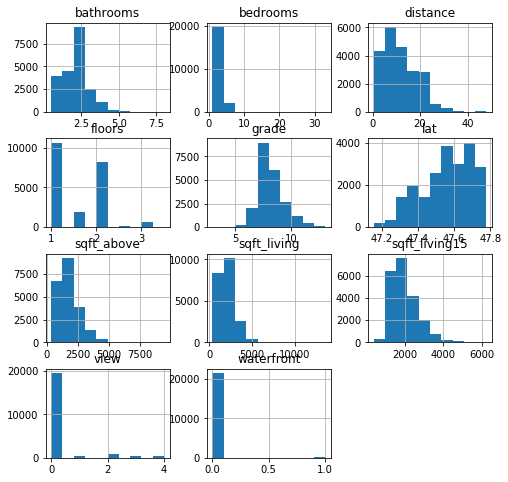

In [41]:
most_impacting.hist(figsize=(8,8))
# note: values for bathrooms and grade could also be considered categorial, in that they're non-infinite
# since the plots above made fairly neat scatter formations, we'll consider them continuous
# view will be treated as categorical - we'll get to that in a bit!
# sqft_basement contains a ton of zeroes, so we can't take the log. We'll come back to that one too!

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c30863410>,
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2c2d2d10>,
      dtype=object)

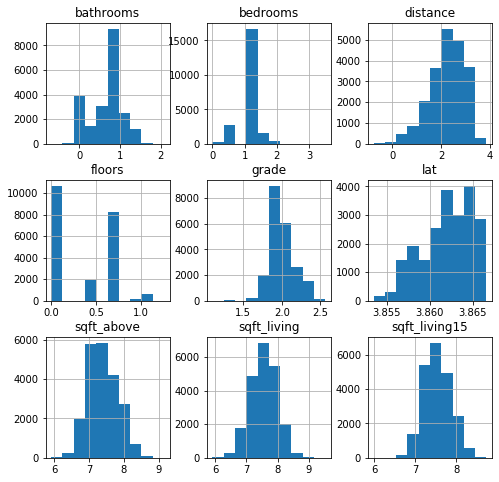

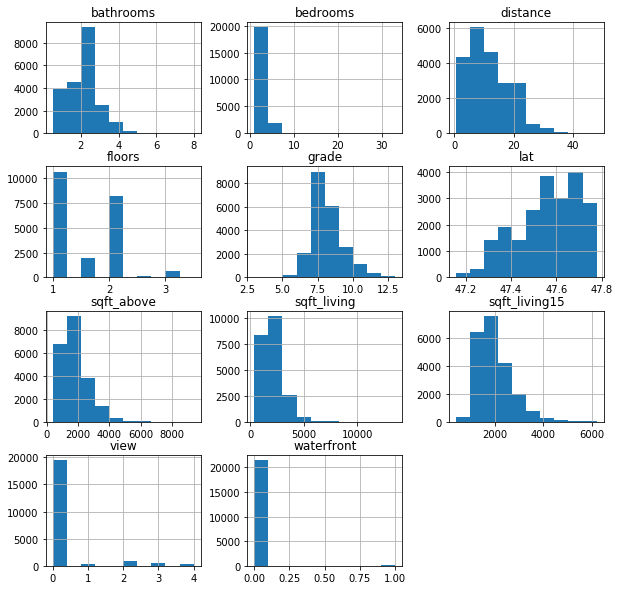

In [42]:
data_log = pd.DataFrame([])

data_log['bathrooms'] = np.log(most_impacting['bathrooms'])
data_log['distance'] = np.log(most_impacting['distance'])
data_log['grade'] = np.log(most_impacting['grade'])
data_log['floors'] = np.log(most_impacting['floors'])
data_log['lat'] = np.log(most_impacting['lat'])
data_log['sqft_above'] = np.log(most_impacting['sqft_above'])
data_log['sqft_living'] = np.log(most_impacting['sqft_living'])
data_log['bedrooms'] = np.log(most_impacting['bedrooms'])
data_log['sqft_living15'] = np.log(most_impacting['sqft_living15'])

display(data_log.hist(figsize=(8,8)))
display(most_impacting.hist(figsize=(10,10)))

# unfortunately, we can't take the log of views or waterfront
# we'll leave them as is for now!

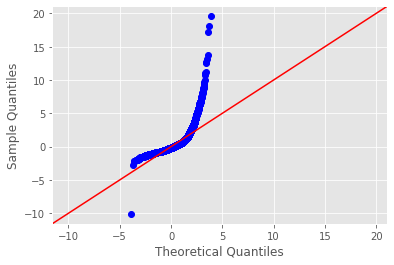

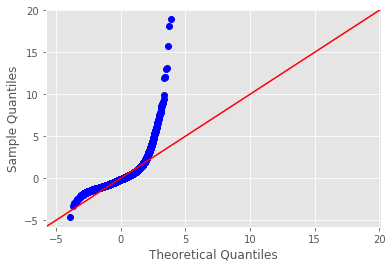

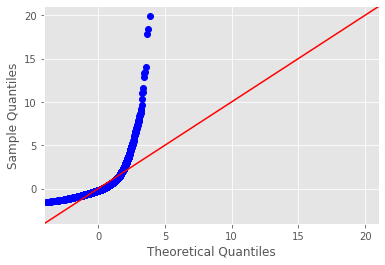

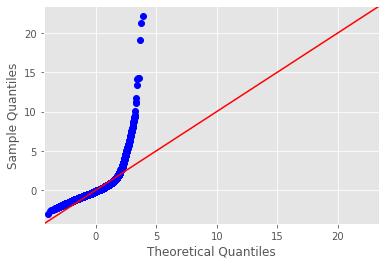

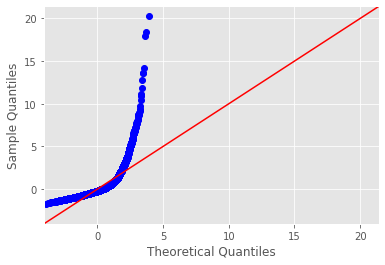

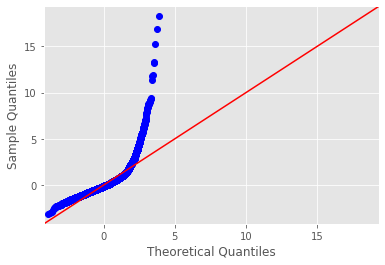

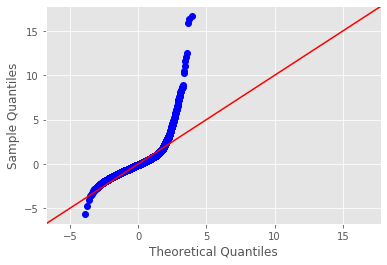

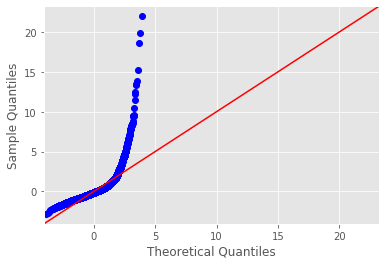

In [43]:
# next, we'll check the qq plots to make sure our data is distributed normally
# this will help us to choose between the original values and the log

import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats
plt.style.use('ggplot')
 
# first, let's do this with the original dataframe, df    
data = df
f = 'price~bedrooms'
f2 = 'price~bathrooms'
f3 = 'price~distance'
f4 = 'price~grade'
f5 = 'price~lat'
f6 = 'price~sqft_above'
f7 = 'price~sqft_living'
f8 = 'price~sqft_living15'
model = smf.ols(formula=f, data=data).fit()
model2 = smf.ols(formula=f2, data=data).fit()
model3 = smf.ols(formula=f3, data=data).fit()
model4 = smf.ols(formula=f4, data=data).fit()
model5 = smf.ols(formula=f5, data=data).fit()
model6 = smf.ols(formula=f6, data=data).fit()
model7 = smf.ols(formula=f7, data=data).fit()
model8 = smf.ols(formula=f8, data=data).fit()

resid1 = model.resid
resid2 = model2.resid
resid3 = model3.resid
resid4 = model4.resid
resid5 = model5.resid
resid6 = model6.resid
resid7 = model7.resid
resid8 = model8.resid
fig = sm.graphics.qqplot(resid1, dist=stats.norm, line='45', fit=True)
fig = sm.graphics.qqplot(resid2, dist=stats.norm, line='45', fit=True)
fig = sm.graphics.qqplot(resid3, dist=stats.norm, line='45', fit=True)
fig = sm.graphics.qqplot(resid4, dist=stats.norm, line='45', fit=True)
fig = sm.graphics.qqplot(resid5, dist=stats.norm, line='45', fit=True)
fig = sm.graphics.qqplot(resid6, dist=stats.norm, line='45', fit=True)
fig = sm.graphics.qqplot(resid7, dist=stats.norm, line='45', fit=True)
fig = sm.graphics.qqplot(resid8, dist=stats.norm, line='45', fit=True)



In [44]:
# To do that, we'll have to pull price into the data_log dataframe
data_log['price'] = np.log(df['price'])

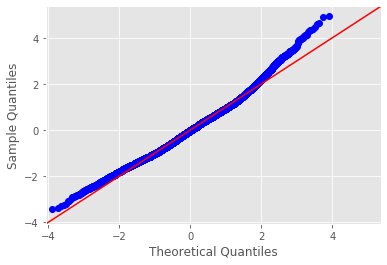

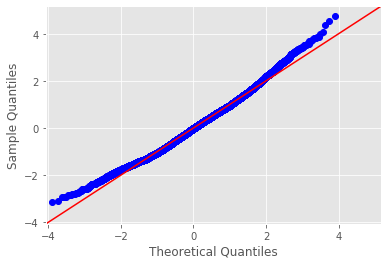

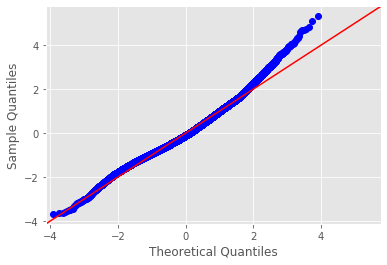

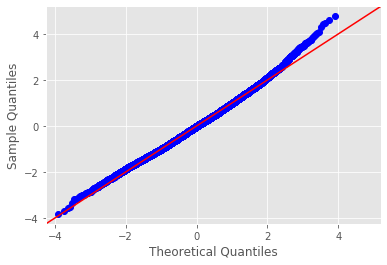

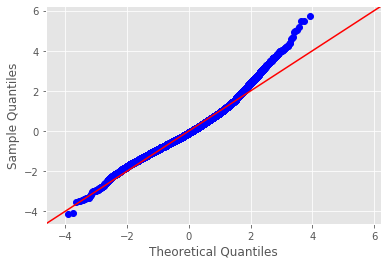

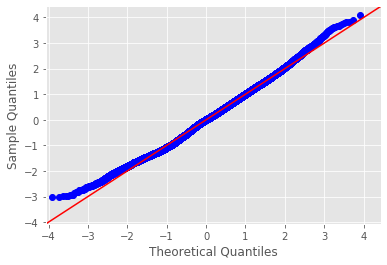

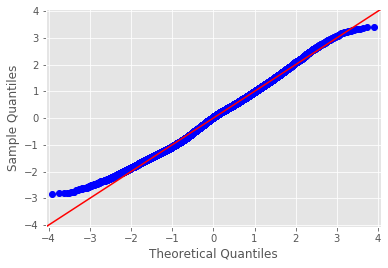

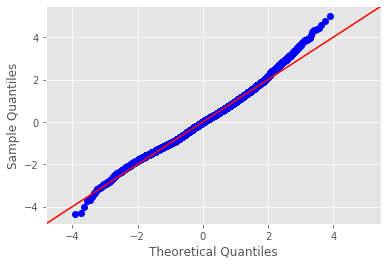

In [45]:
# okay, those don't look great
# let's do the same thing, but using data_log

data = data_log

f = 'price~bedrooms'
f2 = 'price~bathrooms'
f3 = 'price~distance'
f4 = 'price~grade'
f5 = 'price~lat'
f6 = 'price~sqft_above'
f7 = 'price~sqft_living'
f8 = 'price~sqft_living15'
model = smf.ols(formula=f, data=data).fit()
model2 = smf.ols(formula=f2, data=data).fit()
model3 = smf.ols(formula=f3, data=data).fit()
model4 = smf.ols(formula=f4, data=data).fit()
model5 = smf.ols(formula=f5, data=data).fit()
model6 = smf.ols(formula=f6, data=data).fit()
model7 = smf.ols(formula=f7, data=data).fit()
model8 = smf.ols(formula=f8, data=data).fit()

resid1 = model.resid
resid2 = model2.resid
resid3 = model3.resid
resid4 = model4.resid
resid5 = model5.resid
resid6 = model6.resid
resid7 = model7.resid
resid8 = model8.resid
fig = sm.graphics.qqplot(resid1, dist=stats.norm, line='45', fit=True)
fig = sm.graphics.qqplot(resid2, dist=stats.norm, line='45', fit=True)
fig = sm.graphics.qqplot(resid3, dist=stats.norm, line='45', fit=True)
fig = sm.graphics.qqplot(resid4, dist=stats.norm, line='45', fit=True)
fig = sm.graphics.qqplot(resid5, dist=stats.norm, line='45', fit=True)
fig = sm.graphics.qqplot(resid6, dist=stats.norm, line='45', fit=True)
fig = sm.graphics.qqplot(resid7, dist=stats.norm, line='45', fit=True)
fig = sm.graphics.qqplot(resid8, dist=stats.norm, line='45', fit=True)


Much better! Let's use the log transformed values for the qqplots above - bedrooms, bathrooms, distance, grade, lat, sqft_above, sqft_living and and sqft_living15.

Floors and view are categorical - we don't seem to be gaining anything by using the log transformed value.  

In [46]:
most_impacting['bathrooms'] = data_log['bathrooms']
most_impacting['bedrooms'] = data_log['bedrooms']
most_impacting['grade'] = data_log['grade']
most_impacting['distance'] = data_log['distance']
most_impacting['lat'] = data_log['lat']
most_impacting['sqft_above'] = data_log['sqft_above']
most_impacting['sqft_living'] = data_log['sqft_living']
most_impacting['sqft_living15'] = data_log['sqft_living15']

/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [47]:
most_impacting.head()

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,sqft_above,lat,sqft_living15,distance
0,1.098612,0.000000,7.073270,1.0,0.0,0.0,1.945910,7.073270,3.860965,7.200425,2.141589
1,1.098612,0.810930,7.851661,2.0,0.0,0.0,1.945910,7.682482,3.865372,7.432484,1.926383
2,0.693147,0.000000,6.646391,1.0,0.0,0.0,1.791759,6.646391,3.865726,7.908387,2.231934
3,1.386294,1.098612,7.580700,1.0,0.0,0.0,1.945910,6.956545,3.861168,7.215240,2.013084
4,1.098612,0.693147,7.426549,1.0,0.0,0.0,2.079442,7.426549,3.863186,7.495542,2.607448


In [48]:
y = data_log['price']
x = most_impacting
X = sm.add_constant(x)

linreg = sm.OLS(y, X).fit()
linreg.summary()

/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     7769.
Date:                Wed, 20 Nov 2019   Prob (F-statistic):               0.00
Time:                        14:51:44   Log-Likelihood:                 499.09
No. Observations:               21597   AIC:                            -974.2
Df Residuals:                   21585   BIC:                            -878.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -142.2699      2.617    -54.369      0.000    -147.399    -137.141
bedrooms         -0.0852      0.008    -11.033      0.000      -0.100      -0.070
bathrooms         0.0441      0.007      6.255      0.000       0.030       0.058
sqft_living       0.3022      0.011     28.068      0.000       0.281       0.323
floors           -0.0872      0.004    -20.497      0.000      -0.095      -0.079
waterfront        0.4960      0.021     23.295      0.000       0.454       0.538
view              0.0669      0.002     27.642      0.000       0.062       0.072
grade             0.8218      0.019     44.023      0.000       0.785       0.858
sqft_above        0.2444      0.010     24.989      0.000       0.225       0.264
lat              38.3929      0.679     56.567      0.000      37.063      39.723
sqft_living15     0.2763      0.008     34.273      0.000       0.260       0.292
distance         -0.2710      0.003    -87.551      0.000      -0.277      -0.265
==============================================================================
Omnibus:                      566.403   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1359.108
Skew:                           0.070   Prob(JB):                    7.47e-296
Kurtosis:                       4.221   Cond. No.                     2.36e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.36e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now it's time to deal with the values we couldn't log transform - view and waterfront

In [49]:
most_impacting[['view', 'waterfront']].nunique()

view          5
waterfront    2
dtype: int64

Waterfront is binary - no action needed there!
View only has 5 different values - we'll treat this as categorical.

For the view column, we'll:
1. get the dummies and drop one
2. drop the original 'view' column from our dataframe
3. concatenate the working dataframe and the view dummies dataframe

In [50]:
view_dummies = pd.get_dummies(most_impacting['view'], prefix='view', drop_first=True)

In [51]:
most_impacting = most_impacting.drop(['view'], axis=1)

In [52]:
most_impacting = pd.concat([most_impacting, view_dummies], axis=1)
most_impacting.head(10)

,bedrooms,bathrooms,sqft_living,floors,waterfront,grade,sqft_above,lat,sqft_living15,distance,view_1.0,view_2.0,view_3.0,view_4.0
0,1.098612,0.000000,7.073270,1.0,0.0,1.945910,7.073270,3.860965,7.200425,2.141589,0,0,0,0
1,1.098612,0.810930,7.851661,2.0,0.0,1.945910,7.682482,3.865372,7.432484,1.926383,0,0,0,0
2,0.693147,0.000000,6.646391,1.0,0.0,1.791759,6.646391,3.865726,7.908387,2.231934,0,0,0,0
3,1.386294,1.098612,7.580700,1.0,0.0,1.945910,6.956545,3.861168,7.215240,2.013084,0,0,0,0
4,1.098612,0.693147,7.426549,1.0,0.0,2.079442,7.426549,3.863186,7.495542,2.607448,0,0,0,0
5,1.386294,1.504077,8.597851,1.0,0.0,2.397895,8.266164,3.864011,8.468003,2.746690,0,0,0,0
6,1.098612,0.810930,7.447168,2.0,0.0,1.945910,7.447168,3.856715,7.713338,3.072026,0,0,0,0
7,1.098612,0.405465,6.966024,1.0,0.0,1.945910,6.966024,3.858823,7.408531,2.689489,0,0,0,0
8,1.098612,0.000000,7.484369,1.0,0.0,1.945910,6.956545,3.860989,7.484369,2.027186,0,0,0,0
9,1.098612,0.916291,7.544332,2.0,0.0,1.945910,7.544332,3.857955,7.779049,3.117344,0,0,0,0


Looks good! Moving right along.

In [53]:
# one final check, before we run our model for the last time!
most_impacting.isnull().any()

bedrooms         False
bathrooms        False
sqft_living      False
floors           False
waterfront       False
grade            False
sqft_above       False
lat              False
sqft_living15    False
distance         False
view_1.0         False
view_2.0         False
view_3.0         False
view_4.0         False
dtype: bool

Before we move on, let's take another look at the covariance. 
sqft_above is highly correlated with multiple other variables. 
Let's see what our model is like if we remove it.

In [54]:
most_impacting = most_impacting.drop(['sqft_above'], axis=1)

In [55]:
y = data_log['price']
x = most_impacting
X = sm.add_constant(x)

linreg = sm.OLS(y, X).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     6357.
Date:                Wed, 20 Nov 2019   Prob (F-statistic):               0.00
Time:                        14:54:22   Log-Likelihood:                 211.19
No. Observations:               21597   AIC:                            -394.4
Df Residuals:                   21583   BIC:                            -282.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -144.6388      2.652    -54.530      0.000    -149.838    -139.440
bedrooms         -0.0770      0.008     -9.846      0.000      -0.092      -0.062
bathrooms         0.0102      0.007      1.457      0.145      -0.004       0.024
sqft_living       0.4655      0.009     53.792      0.000       0.449       0.482
floors           -0.0305      0.004     -8.323      0.000      -0.038      -0.023
waterfront        0.4732      0.024     19.497      0.000       0.426       0.521
grade             0.9125      0.019     49.140      0.000       0.876       0.949
lat              39.0199      0.688     56.717      0.000      37.671      40.368
sqft_living15     0.3042      0.008     37.589      0.000       0.288       0.320
distance         -0.2453      0.003    -82.529      0.000      -0.251      -0.239
view_1.0          0.1320      0.013      9.825      0.000       0.106       0.158
view_2.0          0.1037      0.008     12.757      0.000       0.088       0.120
view_3.0          0.1771      0.011     16.031      0.000       0.155       0.199
view_4.0          0.2824      0.017     16.854      0.000       0.250       0.315
==============================================================================
Omnibus:                      570.332   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1293.607
Skew:                           0.116   Prob(JB):                    1.25e-281
Kurtosis:                       4.176   Cond. No.                     2.01e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Before moving on, we need to check that our p values are less than .05.
All good there!
We've ended up with a model that can predict with 78% accuracy the sales price of a house, based on the above factors. Pretty cool!

In [60]:
# Before we're finished, let's re-name our working dataset as df. This will help in analysis.

most_impacting = pd.concat([most_impacting, data_log.price], axis=1)
df = most_impacting
df.head(10)

,bedrooms,bathrooms,sqft_living,floors,waterfront,grade,lat,sqft_living15,distance,view_1.0,view_2.0,view_3.0,view_4.0,price
0,1.098612,0.000000,7.073270,1.0,0.0,1.945910,3.860965,7.200425,2.141589,0,0,0,0,12.309982
1,1.098612,0.810930,7.851661,2.0,0.0,1.945910,3.865372,7.432484,1.926383,0,0,0,0,13.195614
2,0.693147,0.000000,6.646391,1.0,0.0,1.791759,3.865726,7.908387,2.231934,0,0,0,0,12.100712
3,1.386294,1.098612,7.580700,1.0,0.0,1.945910,3.861168,7.215240,2.013084,0,0,0,0,13.311329
4,1.098612,0.693147,7.426549,1.0,0.0,2.079442,3.863186,7.495542,2.607448,0,0,0,0,13.142166
5,1.386294,1.504077,8.597851,1.0,0.0,2.397895,3.864011,8.468003,2.746690,0,0,0,0,14.022525
6,1.098612,0.810930,7.447168,2.0,0.0,1.945910,3.856715,7.713338,3.072026,0,0,0,0,12.458775
7,1.098612,0.405465,6.966024,1.0,0.0,1.945910,3.858823,7.408531,2.689489,0,0,0,0,12.583995
8,1.098612,0.000000,7.484369,1.0,0.0,1.945910,3.860989,7.484369,2.027186,0,0,0,0,12.343658
9,1.098612,0.916291,7.544332,2.0,0.0,1.945910,3.857955,7.779049,3.117344,0,0,0,0,12.685408


# 3. Wrapping Up

Which variable has the biggest impact on the sales price of a house?

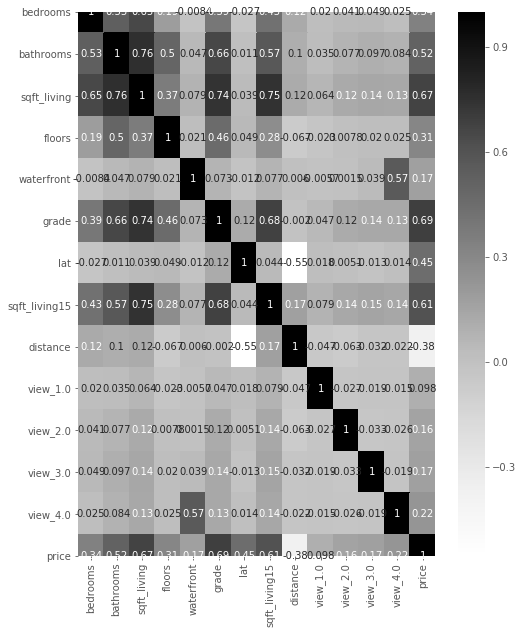

In [61]:
# Easy - let's re-run that heatmap again and look for the largest (absolute) value
correlation = df.corr()
plt.figure(figsize=(8, 10))
heatmap = sns.heatmap(correlation, annot=True, cmap="Greys")

Here's what this means:
* Our highest impacting variable is grade
* Out second is sqft_living
* Our third is sqft_living15
* Next is bathrooms
* Following is lat

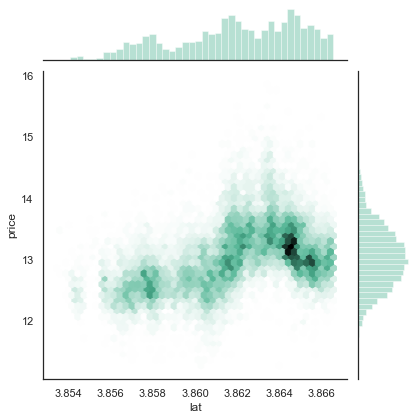

In [62]:
# examining the impact of lat
lat_data = df[['lat', 'price']]
sns.set(style="white")

x = lat_data['lat']
y = lat_data['price']

sns.jointplot(x, y, kind="hex", color="#4CB391")
# in our adjusted dataset, there is a dense cluster in relatively high lat (~3.865)
# there are also some price outliers (high selling price) around lat 3.863
# this also suggestes that lower lats (farther south geographically) have lower selling prices

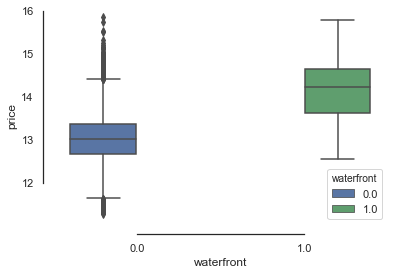

In [63]:
# examining the impact of waterfront
waterfront_data = df[['waterfront', 'price']]
sns.boxplot(x='waterfront', y='price',
            hue='waterfront', palette=['b', 'g'],
            data=waterfront_data)
sns.despine(offset=10, trim=True)
# this shows a significant difference in the quartiles between waterfront and not
# in fact, the first quartile of waterfront homes is higher than the third quartile of not!
# there are also significant outliters in not - high selling price without being by the water

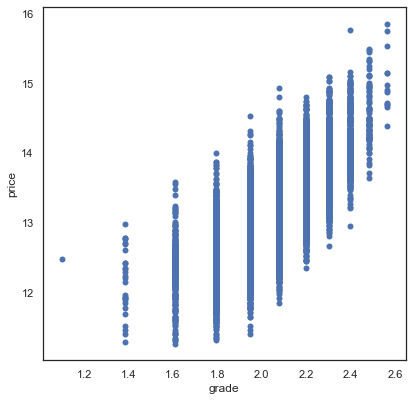

In [64]:
# examining the impact of grade
grade_data = df[['grade', 'price']]
f, ax = plt.subplots(figsize=(6.5, 6.5))
display(sns.scatterplot(x='grade', y='price',
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=grade_data, ax=ax))
# again, the higher the grade the (likely) higher the selling price
# there are relatively few houses sold with grade (adjusted) >4; they all sold for more than the houses with grade < -2

# 4. Other Info


Exploratory analysis for the future: 
* How does the time of house sale impact the price?
* Improve heatmap to show sale price
* Look at average (or median) sales price by year (I would expect this to be high for very old homes and then dip in the middle of the range, increase for more recent builds)

Model fit things for the future:
* Create different dataframes for each zipcode, compare models
* Split data into test/train sets to confirm model fit
* Explore impact of standardizing data

If I did this project again, I'd re-run the last section with non-transformed variables. I know things don't need to be "perfect" but I'd like to get a sense of the real latitude and it's price impact, to use an example. This would have been great to have when building the presentation.